## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


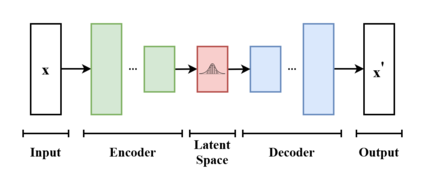

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [ ]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

In [ ]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [ ]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

In [ ]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

In [ ]:
# Example of a training image
plt.imshow(x_tr[1]);

In [ ]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [ ]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [ ]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [ ]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [ ]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

### Visualize Embeddings

In [ ]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

In [ ]:
plt.imshow(x_te_flat[10].reshape(28,28));

In [ ]:
plt.imshow(x_te_flat[13].reshape(28,28));

In [ ]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [ ]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [ ]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

In [ ]:
embedding.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

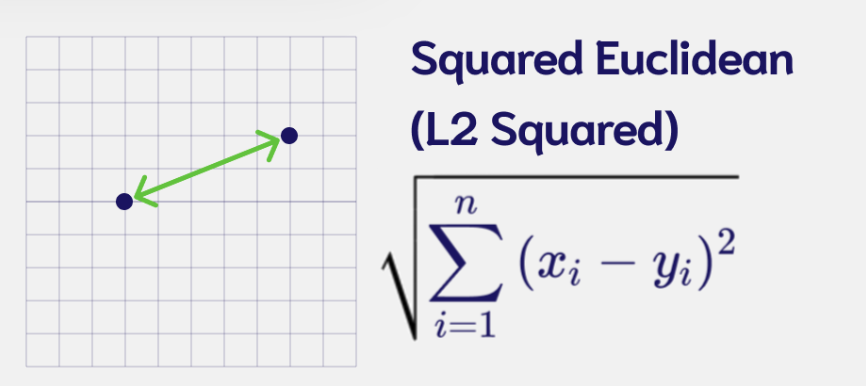

In [ ]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

In [ ]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

In [ ]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

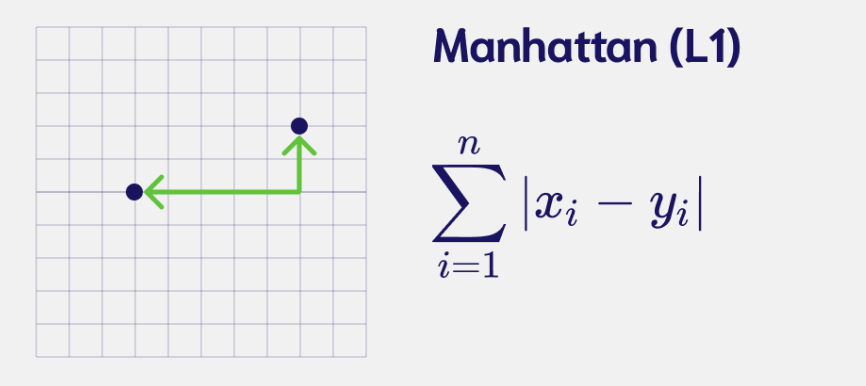

In [ ]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

In [ ]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

In [ ]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

### Dot Product
Measures the magnitude of the projection of one vector onto the other.

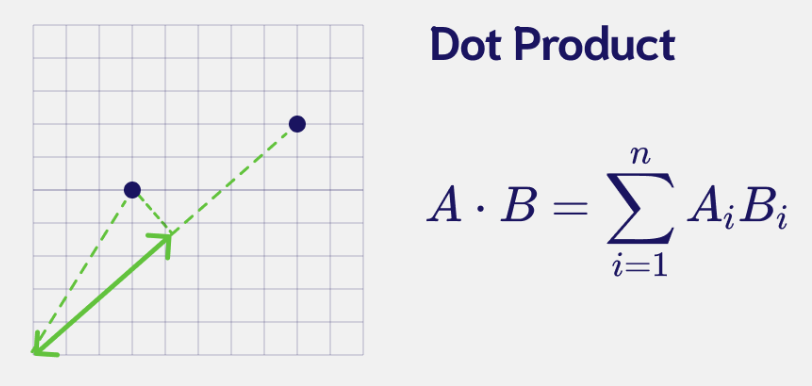

In [ ]:
# Dot Product
np.dot(zero_A,zero_B)

In [ ]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

### Cosine Distance
Measure the difference in directionality between vectors.

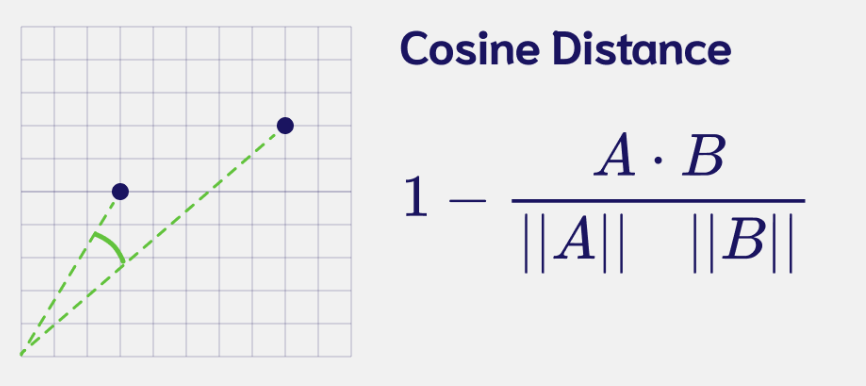

In [ ]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

In [ ]:
zero_A/zero_B

In [ ]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [ ]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [ ]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

In [ ]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))